# <center> Classification non supervisée</center>

## Sommaire :
* [0 - Lecture des données](#0---Lecture-des-données)


* [1 - Transformation des données](#1---Transformation-des-données)

 * [1.1 Coefficients de Fourier](#1.1-Coefficients-de-Fourier)
 * [1.2 Coefficients d'ondelettes](#1.2-Coefficients-d'ondelettes)
 * [1.3 Features](#1.3-Features)
 

* [2 - Analyse en composantes principales](#2---Analyse-en-composantes-principales)


* [3 - Méthodes de clustering sur les séries entières](#3---Méthodes-de-clustering-sur-les-séries-entières)
 * [3.1 Classification ascendante hierarchique (CAH)](#3.1-Classification-ascendante-hierarchique-(CAH))
 * [3.2 Isolation Forest](#3.2-Isolation-Forest)
 * [3.3 One-Class Support Vector Machine (OCSVM)](#3.3-One-Class-Support-Vector-Machine-(OCSVM))
 * [3.4 Local Outlier Factor (LOF)](#3.4-Local-Outlier-Factor-(LOF))


* [4 - Méthodes de clustering sur les fenêtres](#4---Méthodes-de-clustering-sur-les-fenêtres)
 * [4.1 Pre-processing](#4.1-Pre-processing)
 * [4.2 Dimensionality reduction](#4.2-Dimensionality-reduction)
 * [4.3 Application de la méthode OCSVM](#4.3-Application-de-la-méthode-OCSVM)
 * [4.4 Application de la méthode Isolation Forest](#4.4-Application-de-la-méthode-Isolation-Forest)
 * [4.5 Application de la méthode Local Outlier Factor](#4.5-Application-de-la-méthode-Local-Outlier-Factor)

## Téléchargement des librairies

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import itertools

#Fonctions statistiques 
import scipy.stats as sps

# ACP
import sklearn.decomposition as sd
import sklearn.preprocessing as sp
# FFT
from scipy.fftpack import fft
# Hierarchical clustering
import scipy.cluster.hierarchy as sch
#Wavelet
import pywt
from pywt import wavedec
from statsmodels.robust import mad
# LOF
import sklearn.neighbors as sn
# Isolation Forest
import sklearn.ensemble as se
#One Class SVM
import sklearn.svm as ssvm

# Plot et Display
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sb
sb.set()
sb.set_style("darkgrid", {"axes.facecolor": ".9"})

# Interactive display
from ipywidgets import interact, widgets, interactive, fixed, interact_manual
from IPython.display import display

## 0 - Lecture des données

On lit directement les données nettoyées et dont la longueur a été modifiée à 1024 par symétrisation. 
(voir le notebook Lecture et nettoyage des données.ipynb pour plus de détails sur le nettoyage et la symétrisation)

In [2]:
import pickle
with open('X_1024', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    X_1024, ind = mon_depickler.load() #X_1024 : données  #ind : liste des indices des signaux
n = len(X_1024) #nb de signaux
liste_appr = list(np.asarray(X_1024)[np.asarray(ind) <= 299])
liste_test = list(np.asarray(X_1024)[np.asarray(ind) > 299])
n_appr = len(liste_appr)
n_test = len(liste_test)

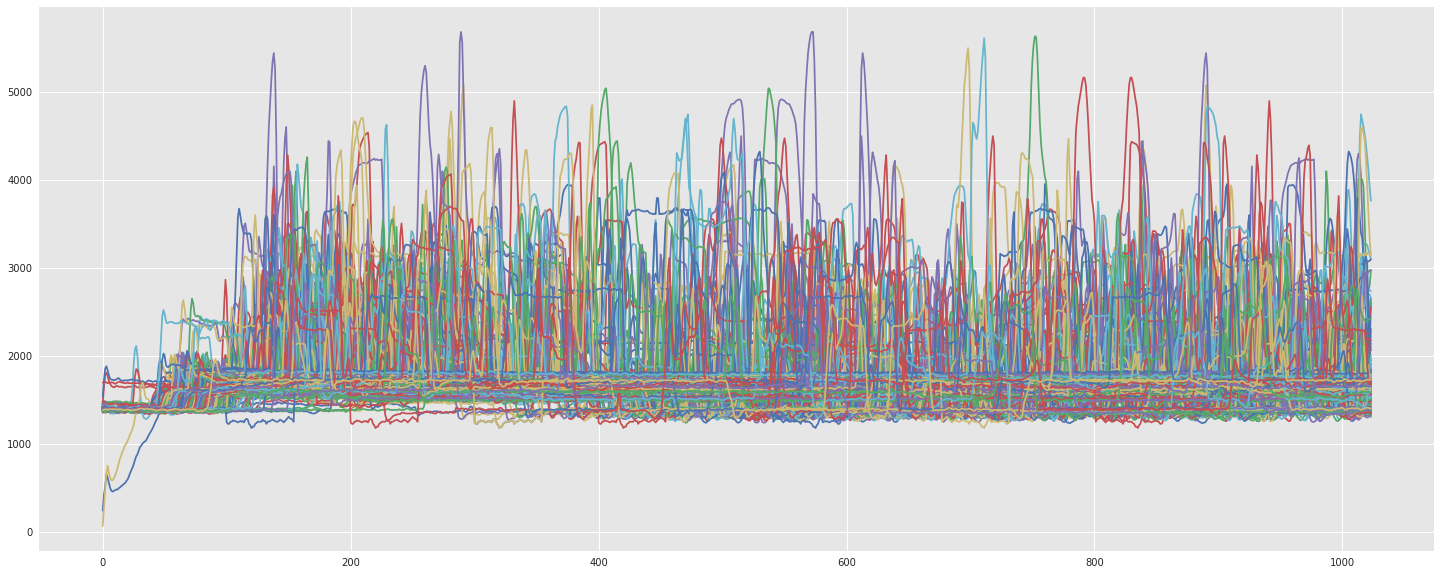

In [3]:
fig = plt.figure(figsize=(25, 10))
for x in X_1024:
    plt.plot(x)

## 1 - Transformation des données

### 1.1 Coefficients de Fourier

On effectue la décomposition de Fourier sur chaque signal. On récupère 2 tableaux de coefficients, l'un avec tous les coefficients et l'autre avec seulement les coefficients les plus importants (ici les 10% les plus importants).

In [4]:
fftCoeff = []

for x in X_1024:
    mx = np.mean(x)
    x_centre = x - mx
    #Apply fast Fourier transform
    coeffsfft = np.abs(fft(x_centre))
    coeffsfft_flatten = np.hstack(coeffsfft)
    fftCoeff.append(coeffsfft_flatten)

fftCoeff = np.array(fftCoeff)
print(fftCoeff.shape)

#Coefficients seuillés
prop_a_garder = 0.1
nb_coeffs = int(fftCoeff.shape[1] * prop_a_garder)
somme = np.sum(fftCoeff**2, axis=0)
fftCoeff_seuil = np.zeros((0, nb_coeffs))
ind_grands = np.argsort(somme)[-nb_coeffs :]
fftCoeff_seuil = fftCoeff[:, ind_grands]

print(fftCoeff_seuil.shape)

(425, 1024)
(425, 102)


### 1.2 Coefficients d'ondelettes

On effectue la décomposition en ondelettes pour chaque signal et on récupère 2 tableaux de coefficients, l'un avec les coefficients de chaque signal dans la base de Haar, l'autre avec les coefficients dans la base Daubechies-2.

In [5]:
wavelist = ['haar','db2'] 

Coeff_ond_haar = []
Coeff_ond_db2 = []

for x in X_1024:
    #Apply wavelet decomposition
    coeffs_haar = pywt.wavedec(x, wavelist[0], level=8) 
    coeffs_flatten_haar = np.hstack(coeffs_haar)
    Coeff_ond_haar.append(coeffs_flatten_haar)
    #Apply wavelet decomposition
    coeffs_db2 = pywt.wavedec(x, wavelist[1], level=8) 
    coeffs_flatten_db2 = np.hstack(coeffs_db2)
    Coeff_ond_db2.append(coeffs_flatten_db2)
    
    
Coeff_ond_haar = np.array(Coeff_ond_haar)
Coeff_ond_db2 = np.array(Coeff_ond_db2)
print(Coeff_ond_haar.shape, Coeff_ond_db2.shape)
print(np.sum(Coeff_ond_haar != 0), np.sum(Coeff_ond_db2 != 0))

(425, 1024) (425, 1041)
304114 440470


#### Choix des coefficients d'ondelettes

On sélectionne différents niveaux de coefficients qui correspondent au niveau de détails que l'on souhaite garder sur les signaux.

In [6]:
#Coefficient de niveau 7 à 10:
Coeff_ond_haar7 = Coeff_ond_haar[:,128:]
Coeff_ond_db2_7 = Coeff_ond_db2[:,128:]
#Coefficient de niveau 1 à 6 : 
Coeff_ond_haarA6 = Coeff_ond_haar[:,:128]
Coeff_ond_db2_A6 = Coeff_ond_db2[:,:128]
#Coefficient de niveau 1 à 4 : 
Coeff_ond_haarA4 = Coeff_ond_haar[:,:16]
Coeff_ond_db2_A4 = Coeff_ond_db2[:,:16]

### 1.3 Features

On récupère les données nettoyées comme précédemment mais dont la longueur n'a pas été modifiée. (voir le notebook Lecture et nettoyage des données.ipynb pour plus de détails sur le nettoyage)

In [7]:
with open('liste_propre', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    liste_comp, ind = mon_depickler.load() #liste_comp : données  #ind : liste des indices des signaux
n = len(liste_comp) #nb de signaux
liste_appr = list(np.asarray(liste_comp)[np.asarray(ind) <= 299])
liste_test = list(np.asarray(liste_comp)[np.asarray(ind) > 299])
n_appr = len(liste_appr)

#### Liste des features  

On sélectionne un certain nombre de features présentés dans l'article https://arc.aiaa.org/doi/pdf/10.2514/6.2016-2430?download=true :
- min
- max
- mean 
- écart type 
- Skewness 
- Kurtosis 
- Energy 
- Average Crossing 

In [8]:
listeMin = [min(liste) for liste in liste_comp]
listeMax = [max(liste) for liste in liste_comp]
listeMean = [np.mean(liste) for liste in liste_comp]
listeStd = [np.std(liste) for liste in liste_comp]
listeSkewness = [sps.skew(liste) for liste in liste_comp]
listeKurtosis = [sps.kurtosis(liste) for liste in liste_comp]
listeEnergy = [sum(np.asarray(liste)**2)/len(liste) for liste in liste_comp]
listeAverageCross = [sum(1*(liste > np.mean(liste)))/len(liste) for liste in liste_comp]

#### Construction du DataFrame

On construit ensuite un DataFrame contenant les résultats obtenus pour chaque features et on crée ensuite, à partir de ce dernier, 2 nouveaux DataFrame correspondant aux ensembles d'apprentissage et de test.

In [9]:
dico = {"Min": listeMin, 
        "Max": listeMax, 
        "Moyenne": listeMean, 
        "Ecart-type": listeStd, 
        "Skewness": listeSkewness, 
        "Kurtosis": listeKurtosis, 
        "Energie": listeEnergy, 
        "Average_Crossing": listeAverageCross}

DataFeatures = pd.DataFrame(dico)

In [10]:
data_train = DataFeatures.iloc[: len(liste_appr), :]
data_test = DataFeatures.iloc[len(liste_appr) :, :]
data_test.describe()

,Min,Max,Moyenne,Ecart-type,Skewness,Kurtosis,Energie,Average_Crossing
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,1.280000e+02,128.000000
mean,1312.140625,3041.000000,1681.131871,256.957453,1.832478,10.296867,2.916155e+06,0.501287
std,119.882931,836.939306,87.738878,128.116474,2.059130,12.165659,3.564267e+05,0.235063
min,72.000000,1624.000000,1524.917609,57.801247,-2.870609,-1.763901,2.362471e+06,0.070284
25%,1302.000000,2458.000000,1613.451399,159.614775,0.145547,2.287839,2.650776e+06,0.235914
50%,1320.000000,2940.000000,1658.573002,216.153077,1.883105,6.979544,2.811549e+06,0.600456
75%,1354.000000,3570.000000,1752.847804,303.359617,3.154531,13.219379,3.138162e+06,0.699531
max,1432.000000,5616.000000,1894.520301,703.874510,6.964047,58.596857,4.084646e+06,0.861538


#### Analyse en Composantes Principales

On effectue une ACP sur le DataFrame complet pour comprendre l'importance de chaque feature et les relations entre eux.

In [11]:
pca = sd.PCA()
C = pca.fit_transform(sp.scale(DataFeatures))

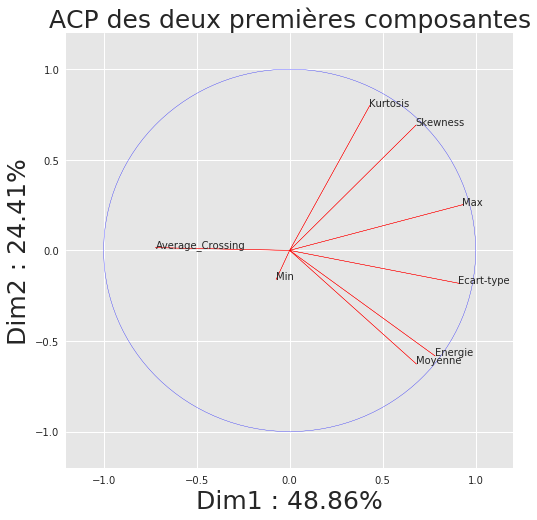

In [12]:
# coordonnées des variables
coord1 = pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2 = pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, DataFeatures.columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='r')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c = plt.Circle((0,0), radius=1, color='b', fill=False)
ax.add_patch(c)
ax.set_xlabel("Dim1 : " + str(round(pca.explained_variance_ratio_[:10][0]*100,2))+ "%" , size=25)
ax.set_ylabel("Dim2 : " + str(round(pca.explained_variance_ratio_[:10][1]*100,2)) + "%", size=25)
ax.set_title("ACP des deux premières composantes",size=25)
plt.show()

In [13]:
Coeff_features = DataFeatures.values.tolist()

## Liste des différents coefficients sur lesquels appliquer les méthodes

Ici, on crée une liste et un dictionnaire des coefficients sur lesquels on va appliquer nos méthodes de détection d'anomalies. Ceci est utile pour utiliser des fonctions interactives qui nous permettent de comparer simplement les résultats obtenus pour chaque coefficient.

In [14]:
#Liste et dictionnaire des coefficients 
#Utile pour les fonctions interactives

Coeff_liste=["Coeffs features",
             "Ondelettes_haar",
             "Ondelettes_haar, niveau 7",
             "Ondelettes_haar, niveaux 1 à 6",
             "Ondelettes_haar, niveau 1 à 4",
             "Ondelettes_db2",
             "Ondelettes_db2, niveau 7",
             "Ondelettes_db2, niveaux 1 à 6",
             "Ondelettes_db2, niveau 1 à 4",
             "Coefficients de Fourier",
             "Coefficients de Fourier seuillés",
             "X_1024"]

dict_coeff ={"Ondelettes_haar": Coeff_ond_haar,
             "Ondelettes_haar, niveau 7": Coeff_ond_haar7,
             "Ondelettes_haar, niveaux 1 à 6": Coeff_ond_haarA6,
             "Ondelettes_haar, niveau 1 à 4": Coeff_ond_haarA4,
             "Ondelettes_db2": Coeff_ond_db2,
             "Ondelettes_db2, niveau 7": Coeff_ond_db2_7,
             "Ondelettes_db2, niveaux 1 à 6": Coeff_ond_db2_A6,
             "Ondelettes_db2, niveau 1 à 4": Coeff_ond_db2_A4,
             "Coefficients de Fourier": fftCoeff,
             "Coefficients de Fourier seuillés": fftCoeff_seuil,
             "X_1024": X_1024,
             "Coeffs features": Coeff_features}

## 2 - Analyse en composantes principales

On effectue d'abord une ACP pour voir la représentation des séries pour chaque type de coefficients et avoir un premier aperçu des séries potentiellement anormales.

### Fonctions d'affichage

In [15]:
def plot_var_ACP(X_acp, acp):
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,2,1)
    N = min(10, X_acp.shape[1])  # Nombre de composantes à afficher
    ax.bar(range(N), acp.explained_variance_ratio_[:N]*100, align='center', color='grey', ecolor='black')
    ax.set_xticks(range(N))
    ax.set_ylabel("Variance")
    ax.set_title("Pourcentage de variance expliquée \n des premières composantes", fontsize=20)

    ax = fig.add_subplot(1,2,2)
    box = ax.boxplot(X_acp[:, 0:N])
    ax.set_title("Distribution des premières composantes", fontsize=20)
    plt.show()
    
def plot_proj_ACP(X_acp, axe_1=0, axe_2=1, etiq=True):
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    dict_color = {True : "blue", False : "red"}

    for x, y, s in zip(X_acp[:,axe_1], X_acp[:,axe_2], ind):
        ax.plot(x,y,marker=".", color=dict_color[s < 300]) #300 : longueur liste apprentissage
        if etiq:
            ax.text(x, y, str(s))
       
    ax.set_title("Projection des invididus sur les \n  deux premières composantes", fontsize=20)

    legend_elements = [Line2D([0], [0], marker='.', color='blue', label='Série du jeu d\'apprentissage', markersize=10, linewidth=0),
                       Line2D([0], [0], marker='.', color='red', label='Série du jeu de test', markersize=10, linewidth=0)]

    ax.legend(handles=legend_elements)

    plt.show()

### Visualisation des résultats

In [16]:
@interact(Choix_coeff=Coeff_liste)
def ACP(Choix_coeff):
    Coeff=dict_coeff[Choix_coeff]
    acp = sd.PCA()
    X_acp = acp.fit_transform(sp.scale(Coeff))
    plot_var_ACP(X_acp, acp)
    plot_proj_ACP(X_acp, axe_1=0, axe_2=1)

interactive(children=(Dropdown(description='Choix_coeff', options=('Coeffs features', 'Ondelettes_haar', 'Onde…

## 3 - Méthodes de clustering sur les séries entières

### 3.1 Classification ascendante hierarchique (CAH)

#### Fonction d'affichage

In [17]:
def plot_dendrogram(Z, p):
    fig = plt.figure(figsize=(25, 10))
    sch.dendrogram(Z, p, leaf_rotation=45.,leaf_font_size=15, truncate_mode="level", labels=ind)  # font size for the x axis labels
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    plt.show()

#### Visualisation des résultats

In [18]:
@interact(Choix_coeff=Coeff_liste, p=widgets.IntSlider(min=1, max=30, step=1, value=6 ,continuous_update=False))
def CAH(Choix_coeff, p):
    Coeff=dict_coeff[Choix_coeff]
    Z = sch.linkage(Coeff, method='average', metric='euclidean')
    C = np.array([c[0] for c in sch.cut_tree(Z,5)])
    CT = pd.DataFrame(list(C), columns=["HCA_cluster"])
    plot_dendrogram(Z, p)

interactive(children=(Dropdown(description='Choix_coeff', options=('Coeffs features', 'Ondelettes_haar', 'Onde…

### Fonction d'affichage des anomalies

In [19]:
def print_anomalies(ind_anomalies,ind_data = ind):
    """Permet d'afficher le bon indice de la série dans le cas où des series ont été supprimées du jeu de données"""
    return [ind_data[i] for i in ind_anomalies]

### 3.2 Isolation Forest

#### Visualisation des résultats

In [20]:
contamination = 20/len(liste_test)
n_estimators = 100

@interact(Choix_coeff=Coeff_liste)
def plot_IF_anomaly(Choix_coeff):
    Coeff = dict_coeff[Choix_coeff]
    Coeff_appr = Coeff[: n_appr]
    Coeff_test = Coeff[n_appr :]
    clf = se.IsolationForest(n_estimators=n_estimators, contamination=contamination, bootstrap=True, behaviour="new", n_jobs=-1)
    pred = clf.fit(Coeff_appr).predict(Coeff_test)
    acp_ond = sd.PCA()
    X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    
    pred_complet = [1] * n_appr + list(pred)
    
    for i, j, anom, s in zip(X_acp_ond[:,0], X_acp_ond[:,1], pred_complet, ind):
        color = "red" if anom!=1  else "grey"
        plt.plot(i, j, "o", color=color) 
        if anom!=1:
            ax.text(i,j,str(s))
    ax.set_title("Repésentation des atypiques sur la projection des 2 premières composantes de l'ACP", fontsize=20)
    plt.show()
    
    print("Séries anormales détectées : ", print_anomalies([i for i, x in enumerate(pred_complet) if x!=1]))

interactive(children=(Dropdown(description='Choix_coeff', options=('Coeffs features', 'Ondelettes_haar', 'Onde…

### 3.3 One-Class Support Vector Machine (OCSVM)

#### Visualisation des résultats

In [21]:
nu = 5/len(liste_appr) # Pourcentage estimé d'outliers dans le jeu d'apprentissage

@interact(Choix_coeff=Coeff_liste)
def plot_OCSVM_anomaly(Choix_coeff):
    Coeff = dict_coeff[Choix_coeff]
    Coeff_appr = Coeff[: n_appr]
    Coeff_test = Coeff[n_appr :]
    
    
    a = 1.e-13
    b = 1
    gamma = (a + b) / 2
    niter = 0
    OCSVM = ssvm.OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
    pred = OCSVM.fit(Coeff_appr).predict(Coeff_test)
    nb_out = np.asarray(pred)[np.asarray(pred) == -1].shape[0]
    while (nb_out < 15 or nb_out > 25) and niter < 500:
        if nb_out > 20 :
            b = gamma
        else :
            a = gamma
        gamma = (a + b) / 2
        OCSVM = ssvm.OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
        pred = OCSVM.fit(Coeff_appr).predict(Coeff_test)
        nb_out = np.asarray(pred)[np.asarray(pred) == -1].shape[0]
        niter += 1
    
    pred_complet = [1] * n_appr + list(pred)

    acp_ond = sd.PCA()
    X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    for i, j, anom, s in zip(X_acp_ond[:,0], X_acp_ond[:,1], pred_complet, ind):
        color = "red" if anom!=1  else "grey"
        plt.plot(i, j, "o",color=color) 
        if anom!=1:
            ax.text(i,j,str(s))
    ax.set_title("Repésentation des atypiques sur la projection des 2 premières composantes de l'ACP", fontsize=20)
    plt.show()
    
    print("Séries anormales détectées : ", print_anomalies([i for i, x in enumerate(pred_complet) if x!=1]))

interactive(children=(Dropdown(description='Choix_coeff', options=('Coeffs features', 'Ondelettes_haar', 'Onde…

### 3.4 Local Outlier Factor (LOF)

#### Visualisation des résultats

In [22]:
contamination = 20/len(liste_test)
metric = 'euclidean'

@interact(Choix_coeff=Coeff_liste, n_neighbors=widgets.IntSlider(min=1,max=30,step=1,value=10, continuous_update=False))
def plot_LOF_anomaly(Choix_coeff, n_neighbors):
    Coeff = dict_coeff[Choix_coeff]
    Coeff_appr = Coeff[: n_appr]
    Coeff_test = Coeff[n_appr :]
    
    clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric, novelty=True)
    #clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric)
    pred = clf.fit(Coeff_appr).predict(Coeff_test)
    pred_complet = [1] * n_appr + list(pred)

    acp_ond = sd.PCA()
    X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    for i, j, anom, s in zip(X_acp_ond[:,0], X_acp_ond[:,1], pred_complet, ind):
        color = "red" if anom!=1  else "grey"
        plt.plot(i, j, "o",color=color) 
        if anom!=1:
            ax.text(i,j,str(s))
    ax.set_title("Repésentation des atypiques sur la projection des 2 premières composantes de l'ACP", fontsize=20)
    plt.show()
    
    print("Séries anormales détectées : ", print_anomalies([i for i,x in enumerate(pred_complet) if x!=1]))

interactive(children=(Dropdown(description='Choix_coeff', options=('Coeffs features', 'Ondelettes_haar', 'Onde…

## 4 - Méthodes de clustering sur les fenêtres

On applique ici la méthode décrite dans l'article https://arc.aiaa.org/doi/pdf/10.2514/6.2016-2430?download=true.
On effectue un fenêtrage des séries puis on calcule les features sur lesquels on va appliquer les 3 méthodes de détection d'anomalies : OCSVM, Isolation Forest, LOF.

### Fonctions d'affichage pour l'ACP sur les fenêtres

In [23]:
def plot_var_ACP_fen(X_acp, acp) :
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,2,1)
    N = min(10, X_acp.shape[1])  # Nombre de composantes à afficher
    ax.bar(range(N), acp.explained_variance_ratio_[:N]*100, align='center', color='grey', ecolor='black')
    ax.set_xticks(range(N))
    ax.set_ylabel("Variance")
    ax.set_title("Pourcentage de variance expliquée \n des premières composantes", fontsize=20)

    ax = fig.add_subplot(1,2,2)
    box = ax.boxplot(X_acp[:, 0:N])
    ax.set_title("Distribution des premières composantes", fontsize=20)
    plt.show()
    
def plot_proj_ACP_fen(X_acp, df, axe_1=0, axe_2=1, etiq=True, create_plot=True) :
    if create_plot:
        fig = plt.figure(figsize=(15,10))
        ax = fig.add_subplot(1,1,1)
    dict_color = {"appr" : "blue", "test" : "red"}

    for x, y, s, orig in zip(X_acp[:,axe_1], X_acp[:,axe_2], df.index.values, df["origine"]) :
        ax.plot(x, y, marker=".", color=dict_color[orig])
        if etiq :
            ax.text(x, y, str(s))
       
    ax.set_title("Projection des invididus sur les \n  deux premières composantes", fontsize=20)

    legend_elements = [Line2D([0], [0], marker='.', color='blue', label='Série du jeu d\'apprentissage', markersize=10, linewidth=0),
                       Line2D([0], [0], marker='.', color='red', label='Série du jeu de test', markersize=10, linewidth=0)]

    ax.legend(handles=legend_elements)
    
    if create_plot:
        plt.show()
    

### 4.1 Pre-processing

#### 4.1.1 Data segmentation

On découpe chaque signal en fenêtre temporelles de longueur fixée. 

Nos signaux étant de longueurs différentes, on doit gérer le cas des fins de signaux qui ne constituent pas une fenêtre complète, par exemple les 150 derniers points d'un signal de longueur 350 pour une fenêtre de longueur 200. L'article ne décrit pas comment gérer ce cas.

On peut penser à plusieurs approches :
* Ignorer ces fins de signaux en espérant ne pas perdre trop d'information
* Utiliser des points de la fenêtre précédente pour arriver à la bonne longueur, quitte à dupliquer de l'information
* Mixer ces deux approches, par exemple (pour une fenêtre de longueur N) en utilisant la première si le nombre de points perdus est inférieur à N/2 et la deuxième sinon.

On commencera par implémenter la première pour des raisons de simplicité.

On range ces fenêtres temporelles dans un DataFrame contenant :
* id : indice de la fenêtre
* serie : numéro de la série temporelle dont provient la fenêtre
* origine : "appr" ou "test" suivant le jeu de données dont provient la série
* ind_debut : indice de la première valeur de la fenêtre dans la série d'origine
* valeurs : liste des N mesures de la fenêtre

In [24]:
def df_fenetres(liste_comp, N):
    serie = []
    origine = []
    ind_debut = []
    valeurs = []
    for i, val in zip(ind, liste_comp):
        # Liste des fenêtres de l'enregistrement
        fenetres = [val[i * N:(i + 1) * N] for i in range((len(val) + N - 1) // N ) if len(val[i * N:(i + 1) * N]) == N]
        nb_fen = len(fenetres)
        valeurs += fenetres
        ind_debut += list(range(0, nb_fen * N, N))
        serie += [i] * nb_fen
        if i < 300:
            origine += ["appr"] * nb_fen
        else:
            origine += ["test"] * nb_fen
        
    
    df = pd.DataFrame(data={"id" : list(range(len(serie))), "serie" : serie, "origine" : origine, "ind_debut" : ind_debut, "valeurs" : valeurs})
        
    return df.set_index(["id"])
        

In [25]:
N = 80 #nombre de points pour les fenêtres
data_fenetres = df_fenetres(liste_comp, N)

#### 4.1.2 Features computation

On sélectionne les features suivant :
- max
- mean 
- écart type 
- Skewness 
- Kurtosis 
- Energy 
- Average Crossing 

In [26]:
data_fenetres["max"] = list(map(max, data_fenetres.valeurs))
data_fenetres["mean"] = list(map(np.mean, data_fenetres.valeurs))
data_fenetres["std"] = list(map(np.std, data_fenetres.valeurs))
data_fenetres["skew"] = list(map(sps.skew, data_fenetres.valeurs))
data_fenetres["kurt"] = list(map(sps.kurtosis, data_fenetres.valeurs))
data_fenetres["energy"] = list(map(lambda x : sum(np.asarray(x)**2)/len(x), data_fenetres.valeurs))
data_fenetres["average_cross"] = list(map(lambda x : sum(1*(x > np.mean(x)))/len(x), data_fenetres.valeurs))

#### 4.1.3 Data normalization

Les features sont normalisées pour qu'elles aient toutes la même influence sur le résultat final.


In [27]:
scaler = sp.StandardScaler()
names_features = ["max", "mean", "std", "skew", "kurt", "energy", "average_cross"]
for col in names_features:
    data_fenetres[col] = scaler.fit_transform(data_fenetres[col].values.reshape(-1, 1))

### 4.2 Dimensionality reduction

On réduit la dimension du problème par ACP. L'article suggère de garder autant de composantes principales que nécessaire pour conserver 95% de la variance, on gardera ici seulement les plus significatives (cf M. Besse).

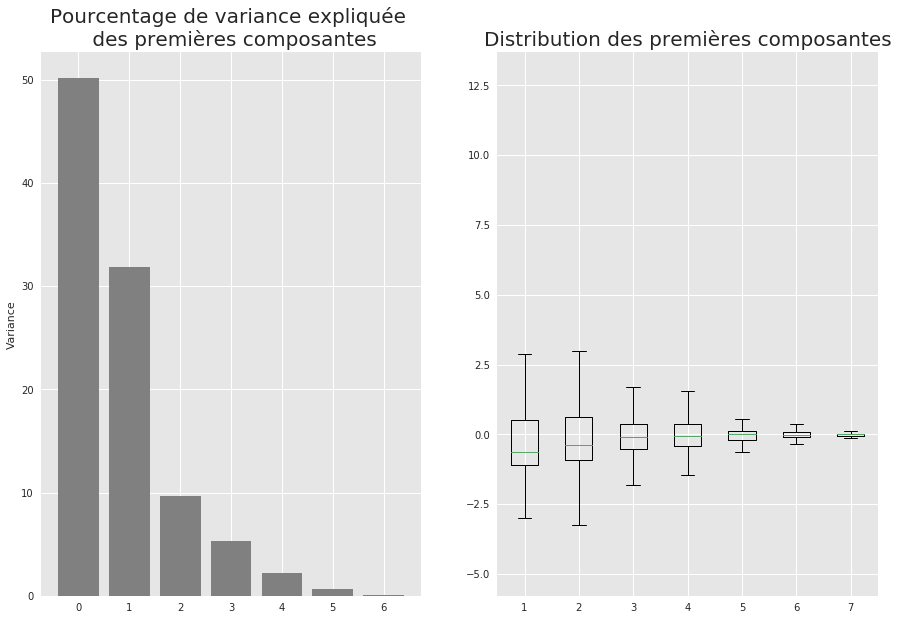

In [28]:
acp = sd.PCA()
X_acp = acp.fit_transform(data_fenetres[names_features])
plot_var_ACP(X_acp, acp)

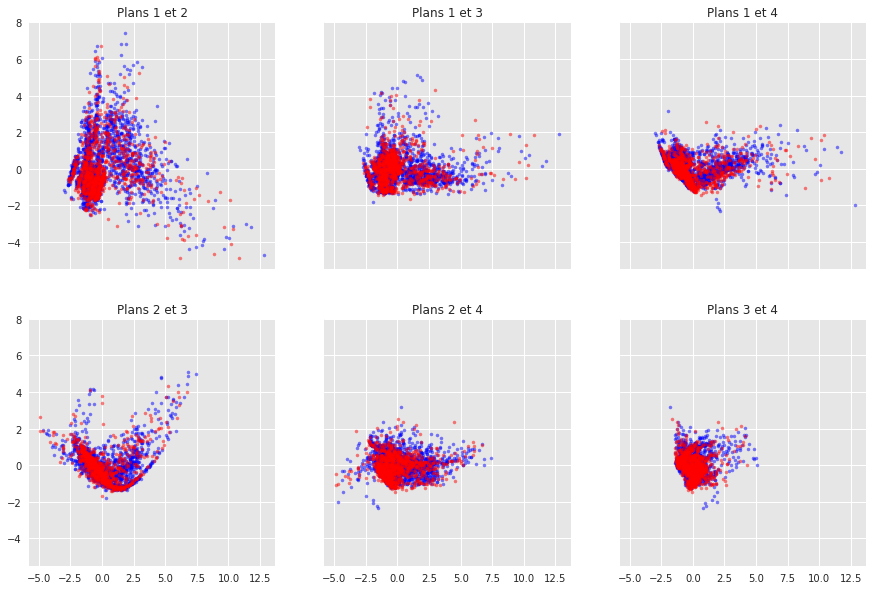

In [29]:
nb_compo = 4

fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15, 10))
dict_color = {"appr" : "blue", "test" : "red"}

for ax, plans in zip(axs.flatten(), itertools.combinations(range(nb_compo), 2)):
    for x, y, s, orig in zip(X_acp[:, plans[0]], X_acp[:, plans[1]], data_fenetres.index.values, data_fenetres["origine"]) :
        ax.plot(x, y, marker=".", color=dict_color[orig], alpha=0.5)

    ax.set_title("Plans " + str(plans[0] + 1) + " et " + str(plans[1] + 1))

plt.show()

### 4.3 Application de la méthode OCSVM

On applique One-Class SVM sur les coordonnées de l'ACP.

In [30]:
C1, C2, C3, C4 = X_acp[:, 0:4].T
data_fenetres["Coord_1"] = C1
data_fenetres["Coord_2"] = C2
data_fenetres["Coord_3"] = C3
data_fenetres["Coord_4"] = C4

In [31]:
names_coord = ["Coord_1", "Coord_2", "Coord_3", "Coord_4"]

In [32]:
data_train = data_fenetres[data_fenetres["origine"] == "appr"][names_coord]
data_test = data_fenetres[data_fenetres["origine"] == "test"][names_coord]

outlier_prop = 5 / 297  # Proportion estimée d'outliers dans le jeu d'apprentissage

A défaut de mieux, on calibre gamma par recherche dichotomique pour avoir entre 15 et 25 outliers.

In [33]:
a = 1.e-13
b = 1
gamma = (a + b) / 2
niter = 0
OCSVM = ssvm.OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=gamma)
y_pred = OCSVM.fit(data_train).predict(data_test)
nb_out = np.asarray(y_pred)[np.asarray(y_pred) == -1].shape[0]
while (nb_out < 19 or nb_out > 21) and niter < 5 * 1e2:
    if nb_out > 20 :
        b = gamma
    else :
        a = gamma
    gamma = (a + b) / 2
    OCSVM = ssvm.OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=gamma)
    y_pred = OCSVM.fit(data_train).predict(data_test)
    nb_out = np.asarray(y_pred)[np.asarray(y_pred) == -1].shape[0]
    niter += 1
print('gamma : ', gamma)
print('nb_out : ', nb_out)

gamma :  0.031250000000096874
nb_out :  21


In [34]:
first_ind_test = data_fenetres[data_fenetres["origine"] == "test"].index[0]

In [35]:
y_pred = np.array(y_pred)
ind_anom = list(np.where(y_pred == -1)[0] + first_ind_test)
data_anom = data_fenetres[data_fenetres["origine"] == "test"].loc[ind_anom, :]

On peut représenter les fenêtres anormales en rouge :

In [36]:
data_fen_test = data_fenetres[data_fenetres["origine"] == "test"]
data_fen_test["anomalie"] = (-y_pred + 1) // 2

/usr/local/insa/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [37]:
ind_series_anom = np.unique(data_fen_test[data_fen_test["anomalie"] == 1]["serie"].values)

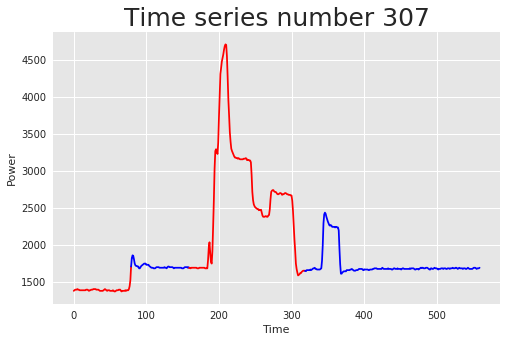

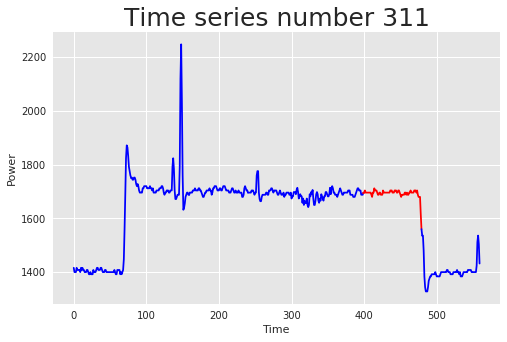

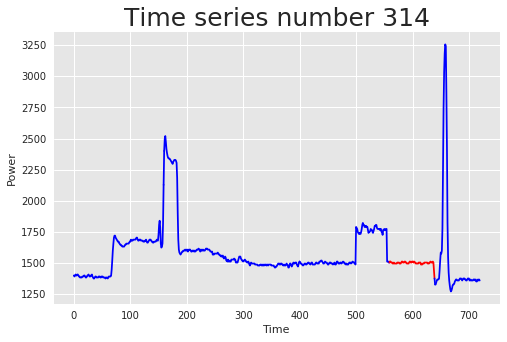

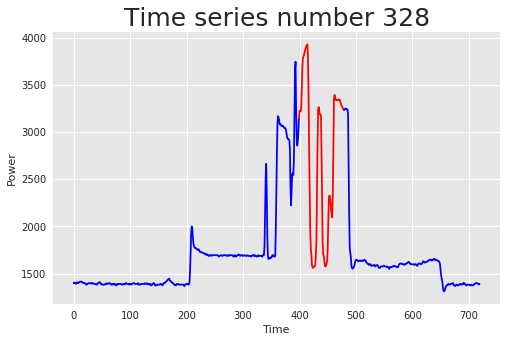

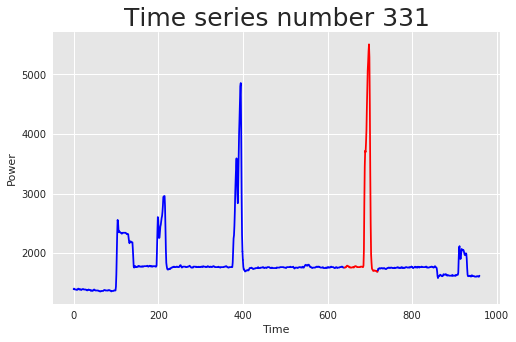

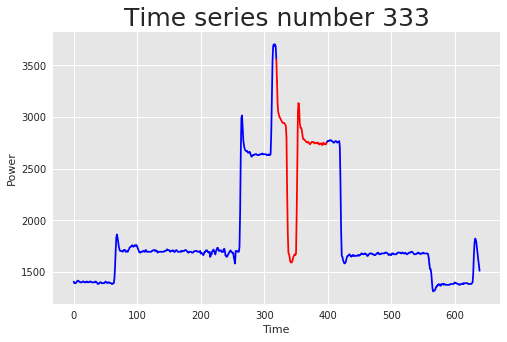

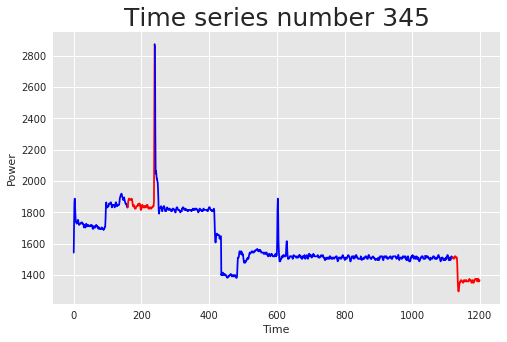

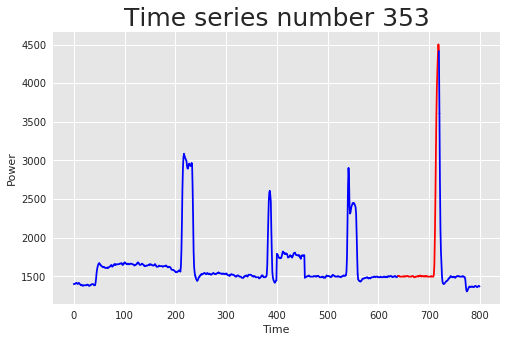

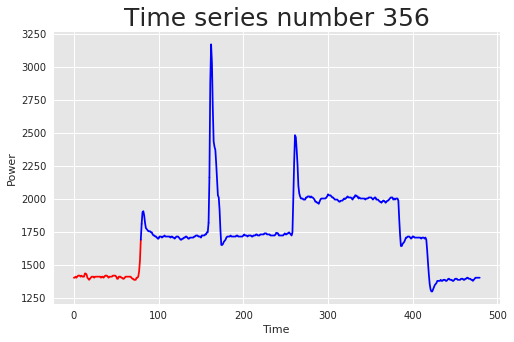

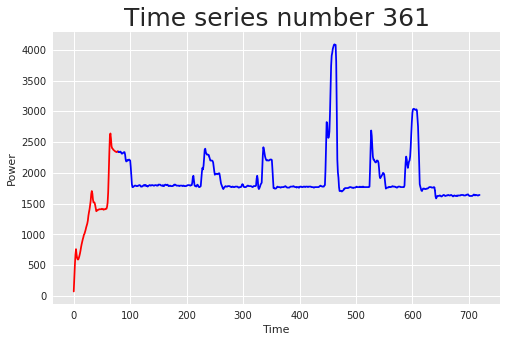

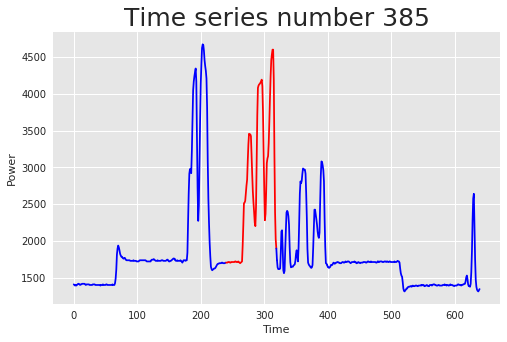

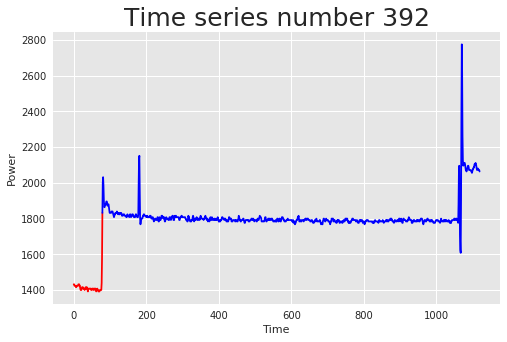

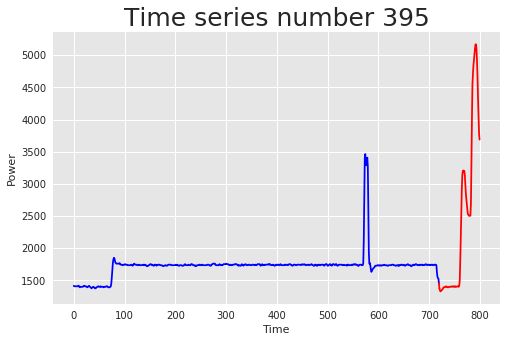

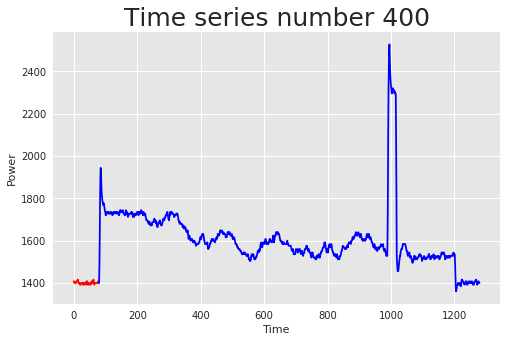

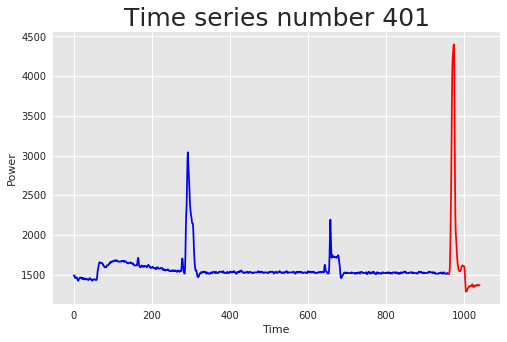

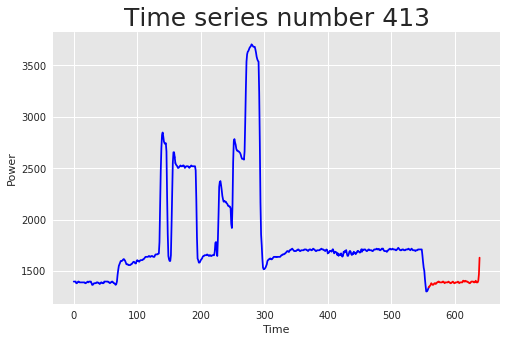

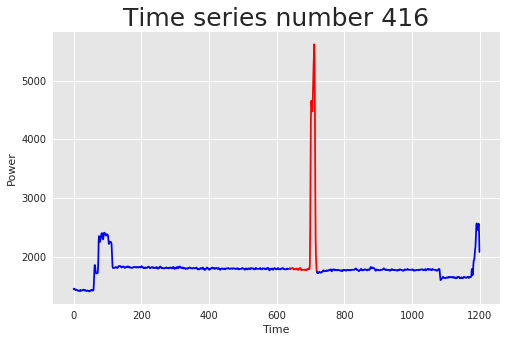

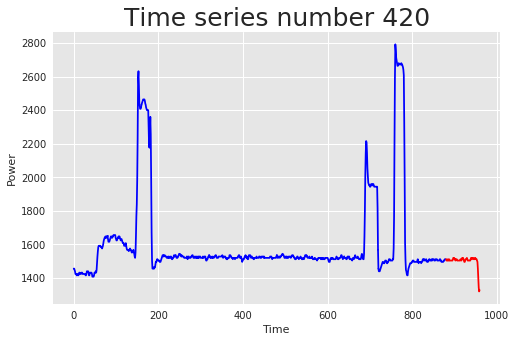

In [38]:
for num in ind_series_anom:
    fig, ax = plt.subplots(figsize=(8, 5))
    TS = data_fen_test[data_fen_test["serie"] == num]["valeurs"].values
    anoms = data_fen_test[data_fen_test["serie"] == num]["anomalie"].values
    title_obj = plt.title("Time series number " + str(num), size=25)
    for (i, x), anom in zip(enumerate(TS), anoms):
        
        if i > 0:  # Raccordement
            ax.plot([N * i - 1, N * i], [last, x[0]], "br"[anom])

        ax.plot(range(N * i, N * (i + 1)),  x, "br"[anom])
        ax.set_xlabel("Time")
        ax.set_ylabel("Power")
        last = x[-1]
    
    plt.show()

In [39]:
print("Séries anormales détectées : ", list(ind_series_anom))

Séries anormales détectées :  [307, 311, 314, 328, 331, 333, 345, 353, 356, 361, 385, 392, 395, 400, 401, 413, 416, 420]


**Bilan : On détecte plus les pics que les réelles anomalies.**

Contrairement à l'article qui n'utilise que OC-SVM, nous appliquons également les méthodes Isolation Forest et Local Outlier Factor.

### 4.4 Application de la méthode Isolation Forest

In [40]:
contamination=20/425
n_estimators=100
clf = se.IsolationForest(n_estimators=n_estimators, contamination=contamination, bootstrap=True, behaviour="new", n_jobs=-1)
y_pred = clf.fit(data_fenetres[names_coord]).predict(data_test)

In [41]:
y_pred = np.array(y_pred)
ind_anom = list(np.where(y_pred == -1)[0] + first_ind_test)
data_anom = data_fenetres[data_fenetres["origine"] == "test"].loc[ind_anom, :]

In [42]:
data_fen_test = data_fenetres[data_fenetres["origine"] == "test"]
data_fen_test["anomalie"] = (-y_pred + 1) // 2

/usr/local/insa/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
ind_series_anom = np.unique(data_fen_test[data_fen_test["anomalie"] == 1]["serie"].values)

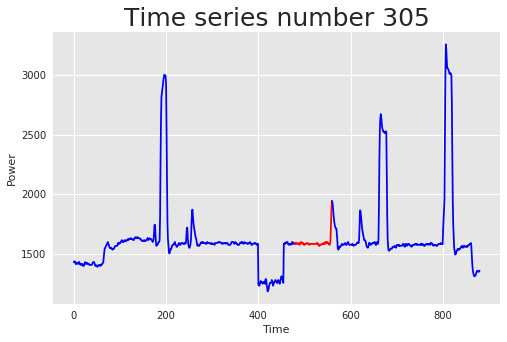

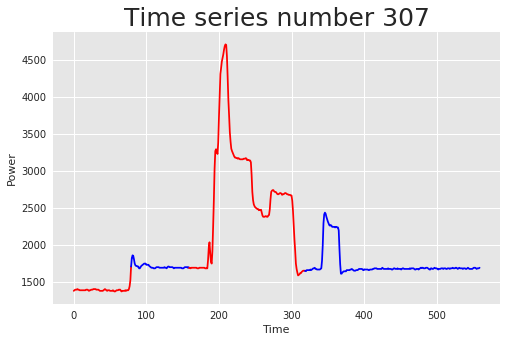

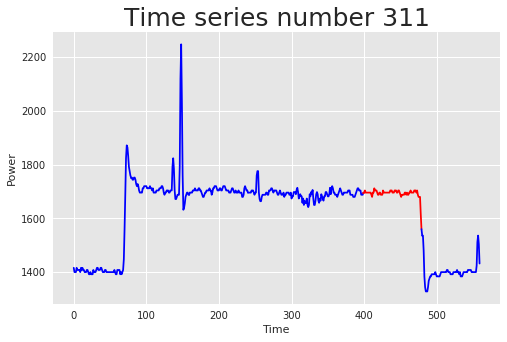

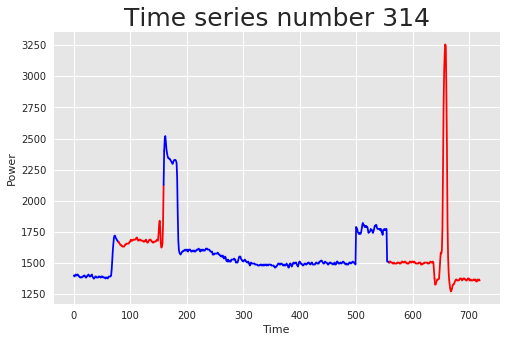

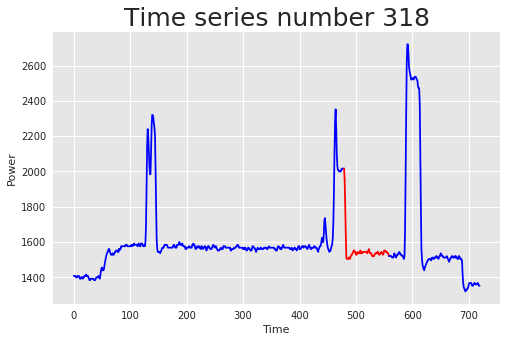

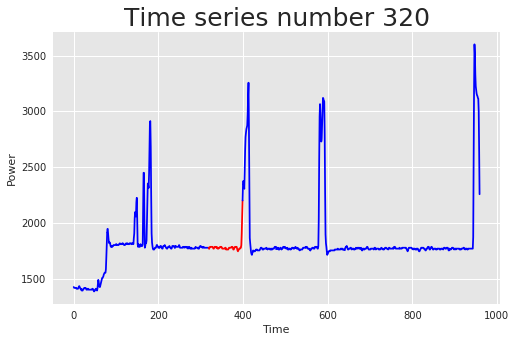

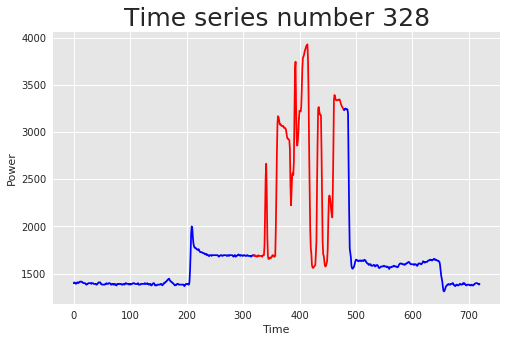

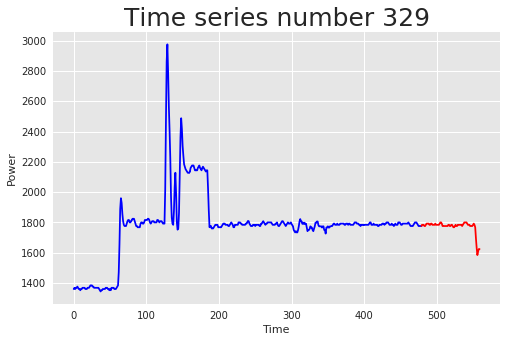

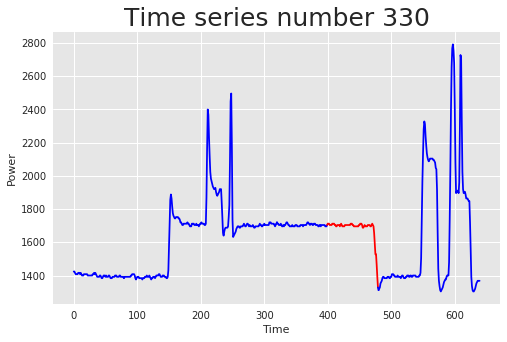

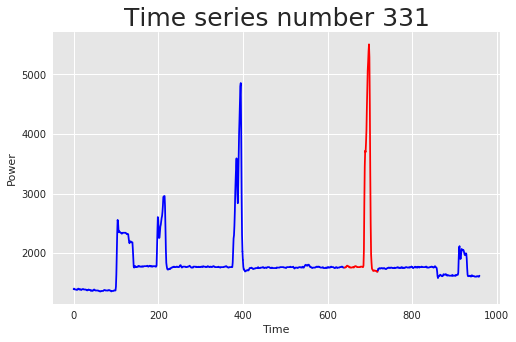

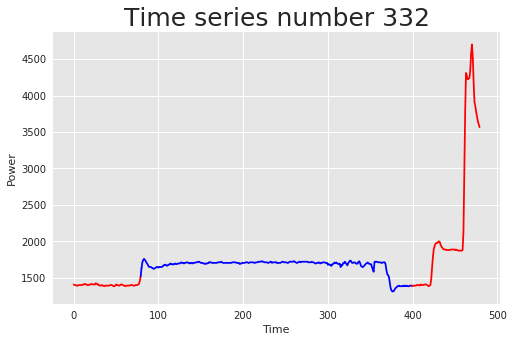

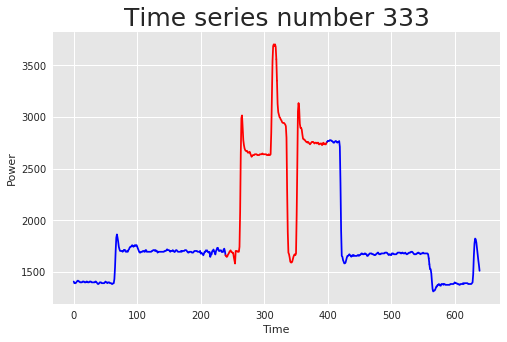

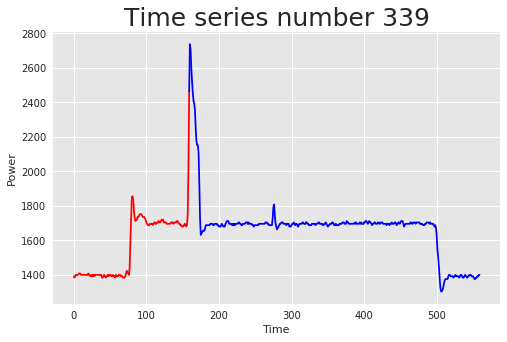

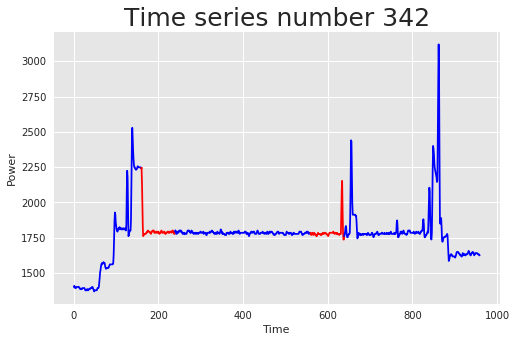

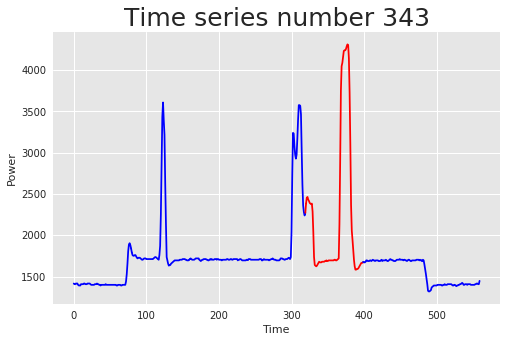

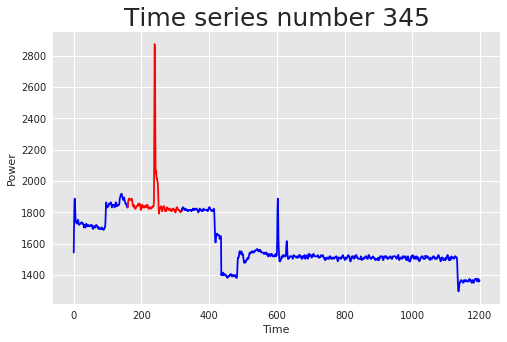

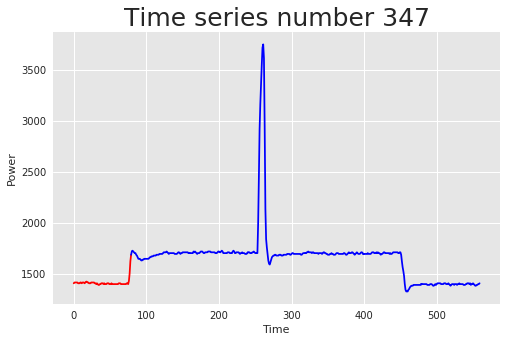

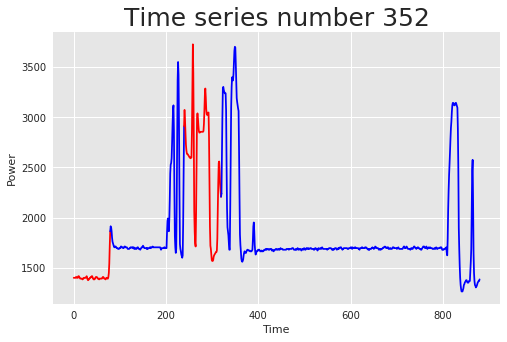

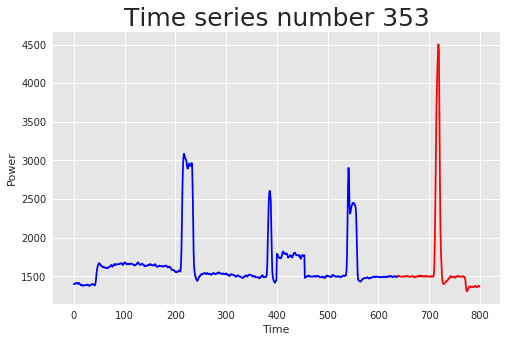

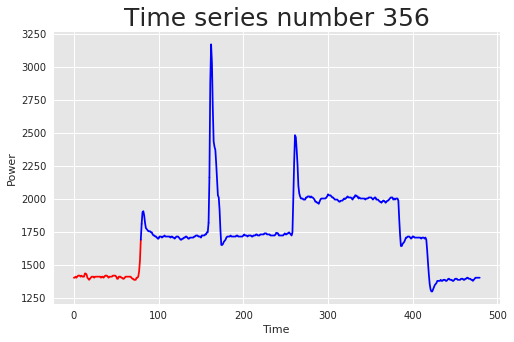

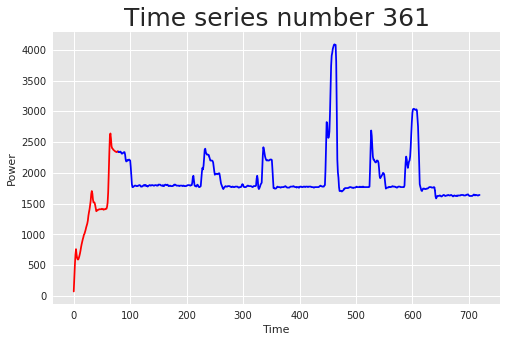

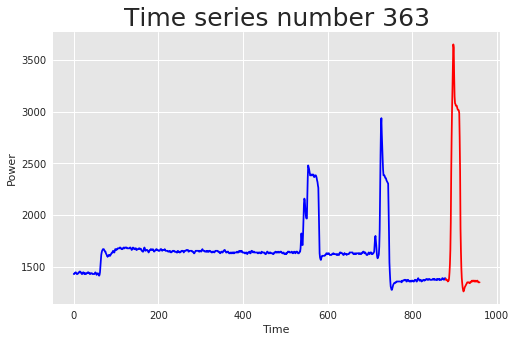

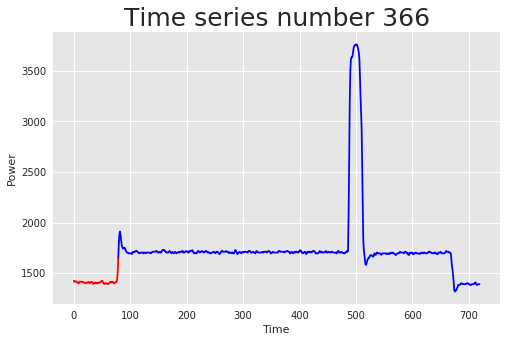

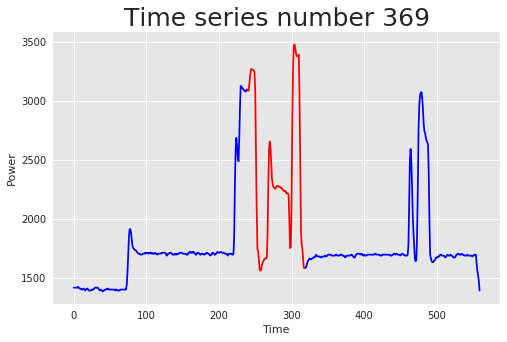

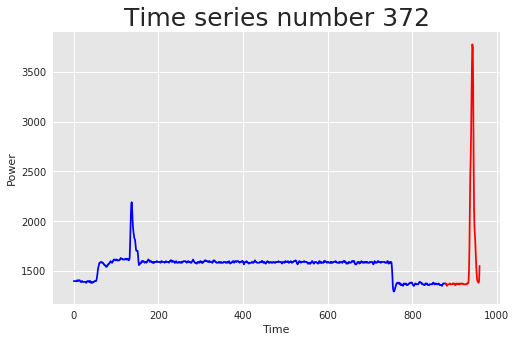

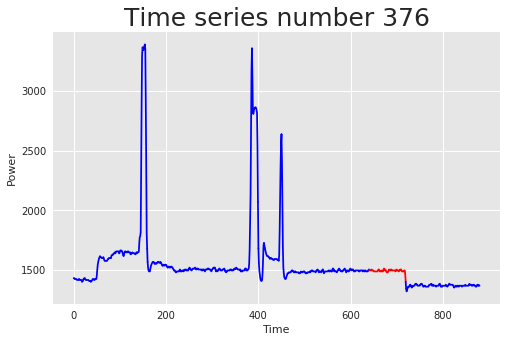

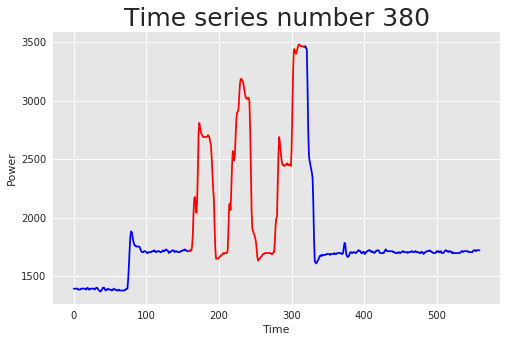

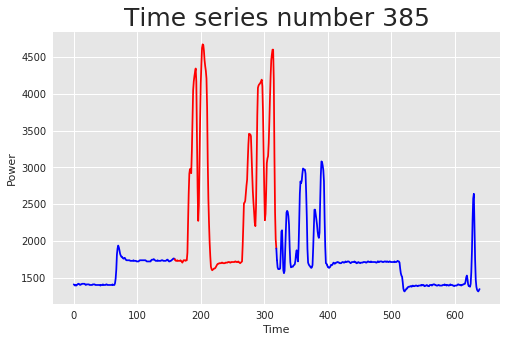

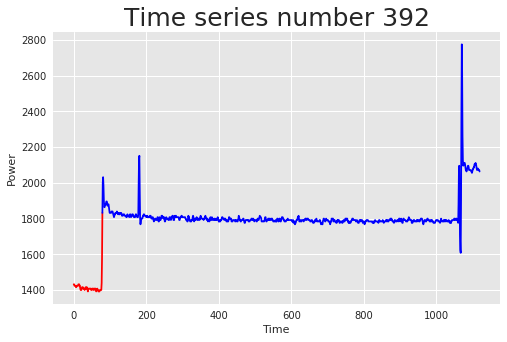

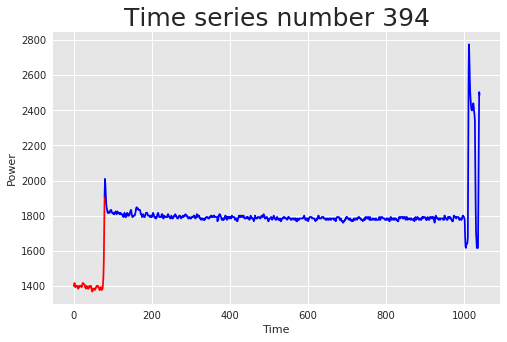

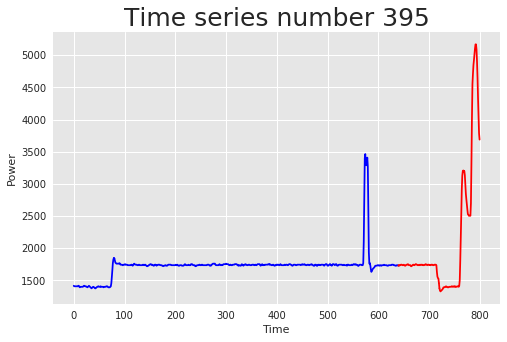

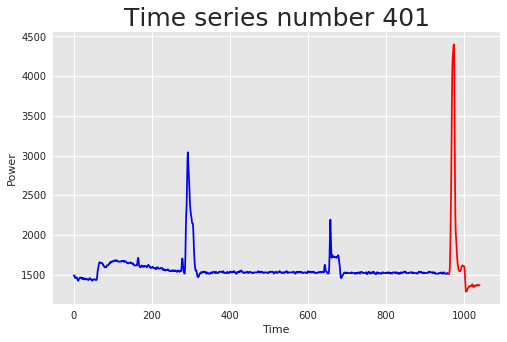

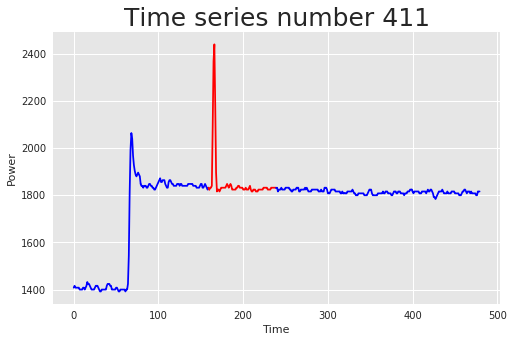

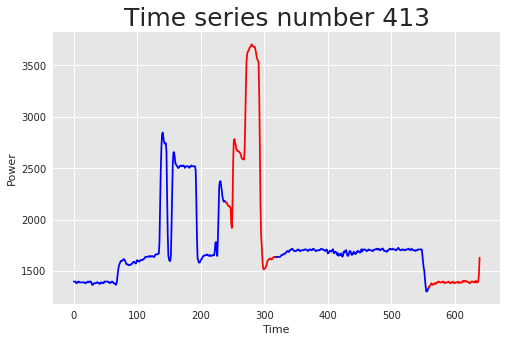

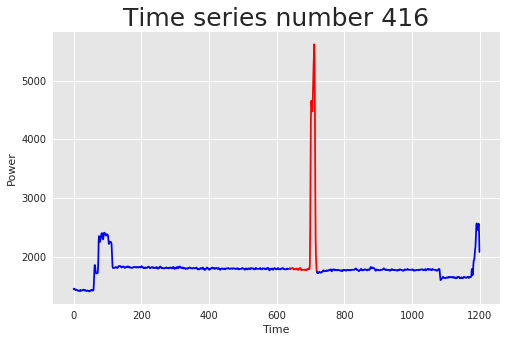

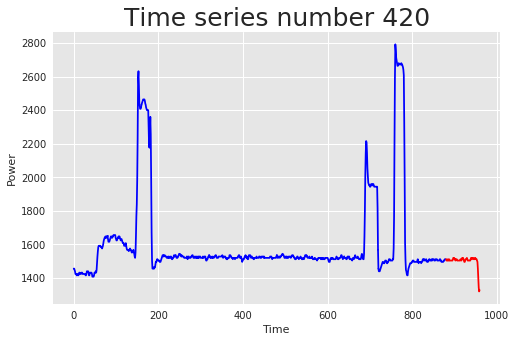

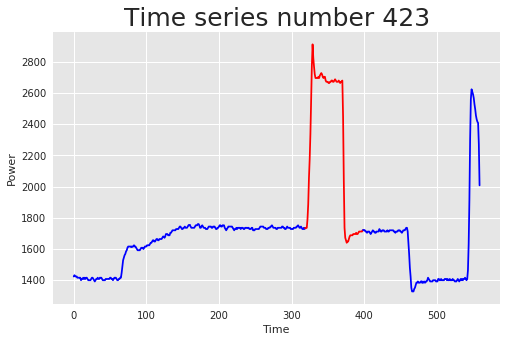

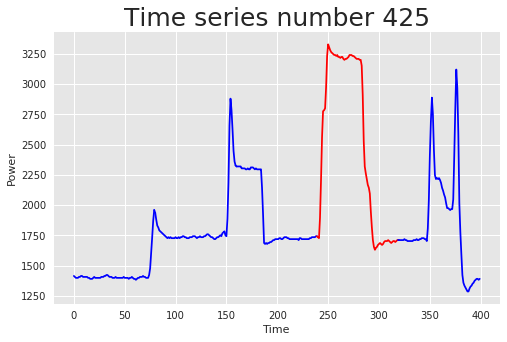

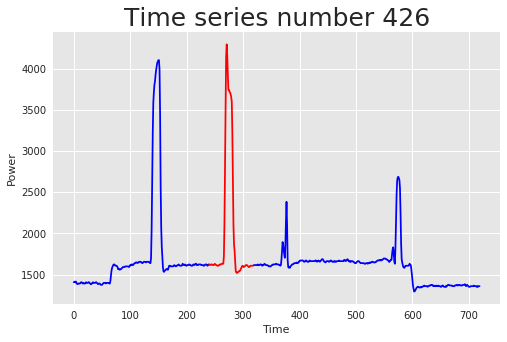

In [44]:
for num in ind_series_anom:
    fig, ax = plt.subplots(figsize=(8, 5))
    TS = data_fen_test[data_fen_test["serie"] == num]["valeurs"].values
    anoms = data_fen_test[data_fen_test["serie"] == num]["anomalie"].values
    title_obj = plt.title("Time series number " + str(num), size=25)
    for (i, x), anom in zip(enumerate(TS), anoms):
        
        if i > 0:  # Raccordement
            ax.plot([N * i - 1, N * i], [last, x[0]], "br"[anom])

        ax.plot(range(N * i, N * (i + 1)),  x, "br"[anom])
        ax.set_xlabel("Time")
        ax.set_ylabel("Power")
        last = x[-1]
    
    plt.show()

In [45]:
print("Séries anormales détectées : ", list(ind_series_anom))

Séries anormales détectées :  [305, 307, 311, 314, 318, 320, 328, 329, 330, 331, 332, 333, 339, 342, 343, 345, 347, 352, 353, 356, 361, 363, 366, 369, 372, 376, 380, 385, 392, 394, 395, 401, 411, 413, 416, 420, 423, 425, 426]


**Bilan : Comme pour OC-SVM, on détecte plus les pics que les réelles anomalies.**

### 4.5 Application de la méthode Local Outlier Factor

In [46]:
contamination=20/425
metric = "euclidean"
n_neighbors = 10

clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric, novelty=True)
y_pred = clf.fit(data_fenetres[names_coord]).predict(data_test)

In [47]:
y_pred = np.array(y_pred)
ind_anom = list(np.where(y_pred == -1)[0] + first_ind_test)
data_anom = data_fenetres[data_fenetres["origine"] == "test"].loc[ind_anom, :]

In [48]:
data_fen_test = data_fenetres[data_fenetres["origine"] == "test"]
data_fen_test["anomalie"] = (-y_pred + 1) // 2

/usr/local/insa/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [49]:
ind_series_anom = np.unique(data_fen_test[data_fen_test["anomalie"] == 1]["serie"].values)

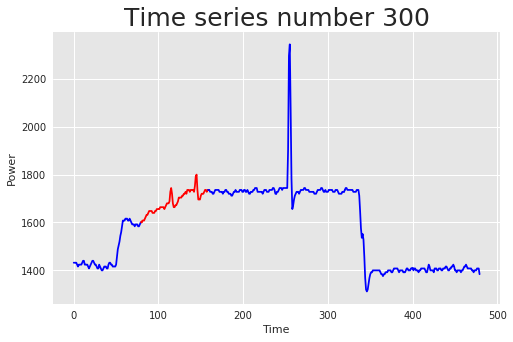

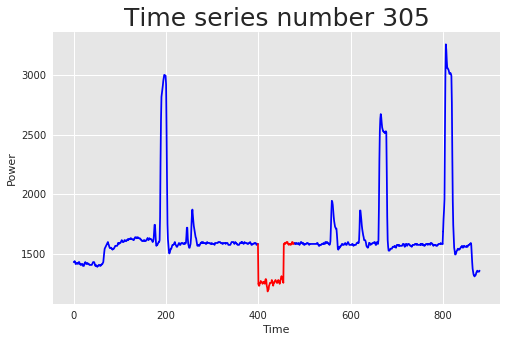

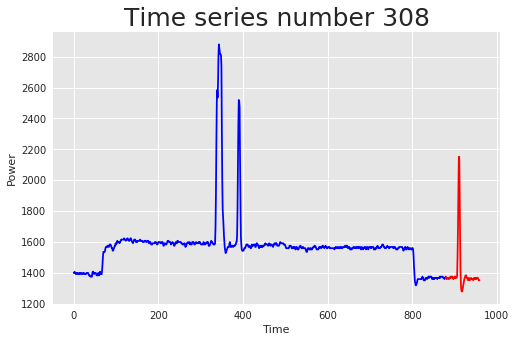

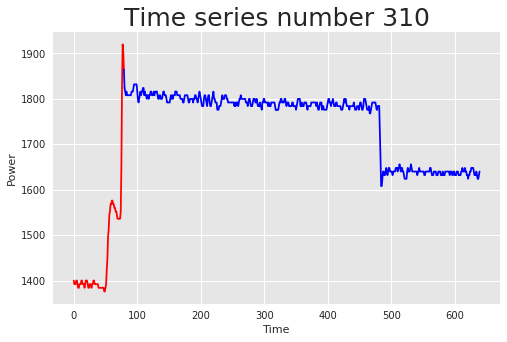

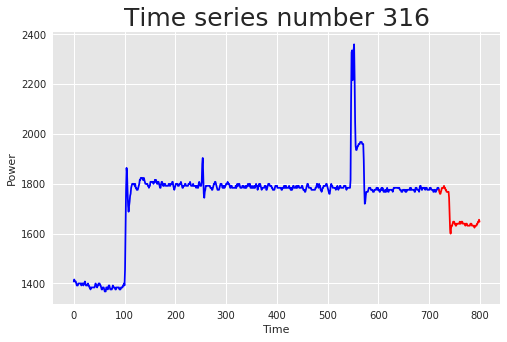

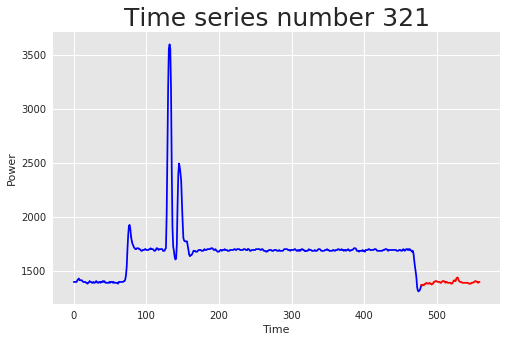

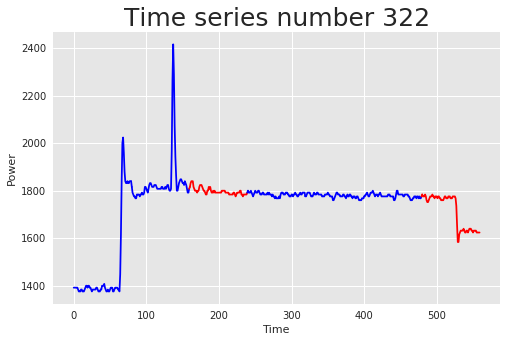

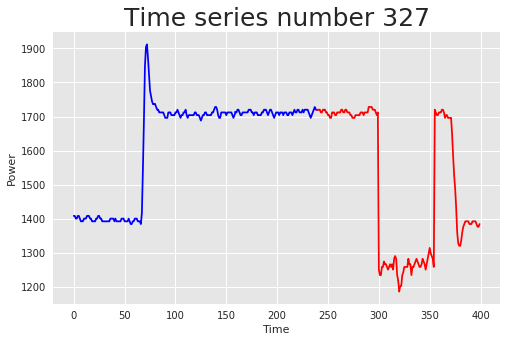

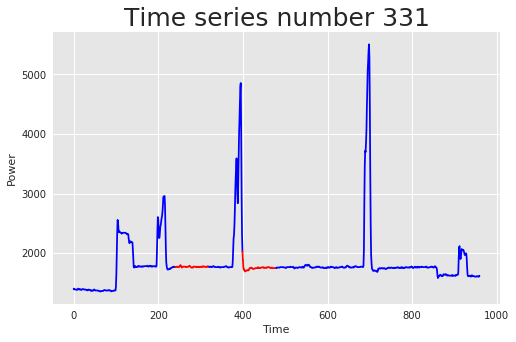

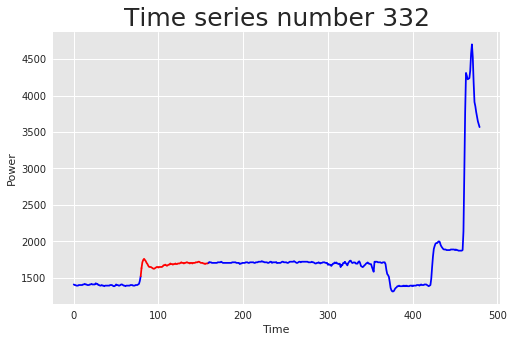

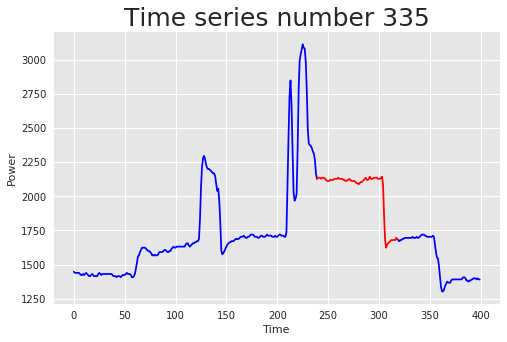

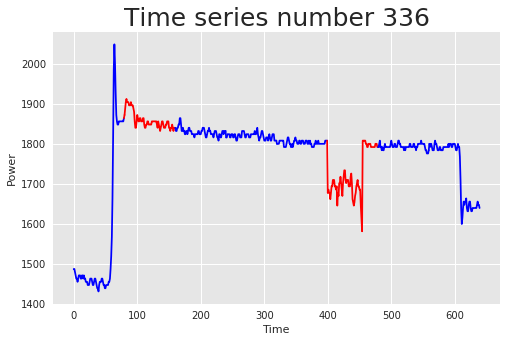

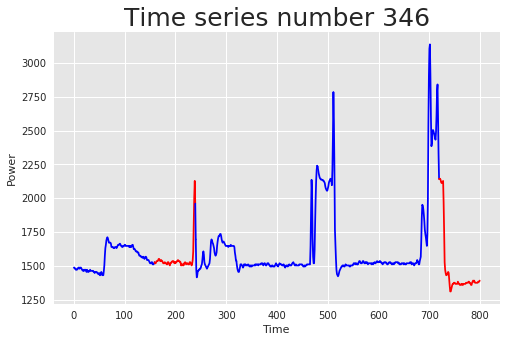

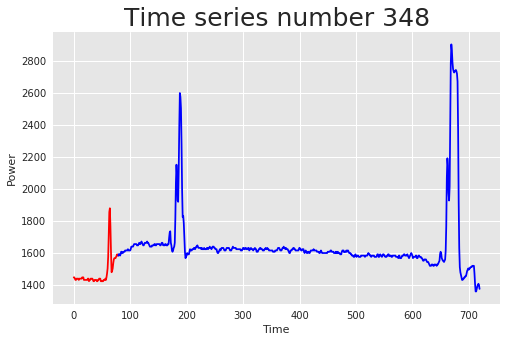

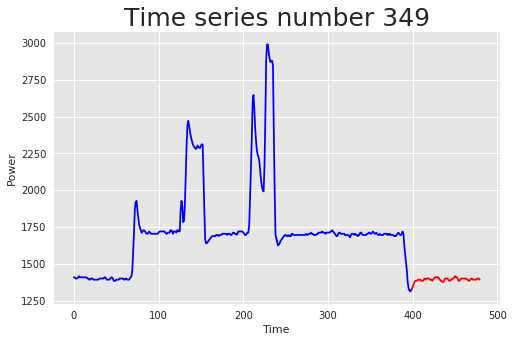

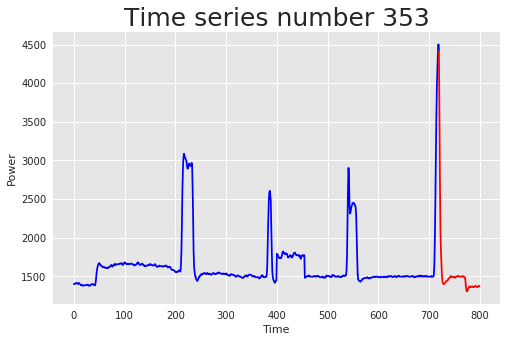

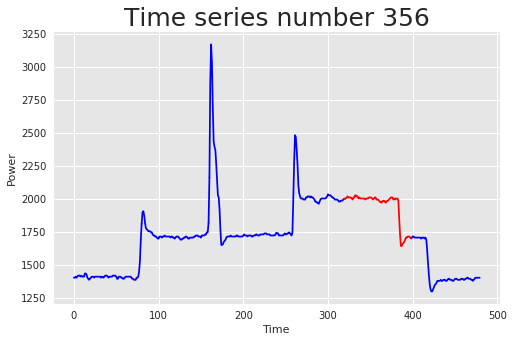

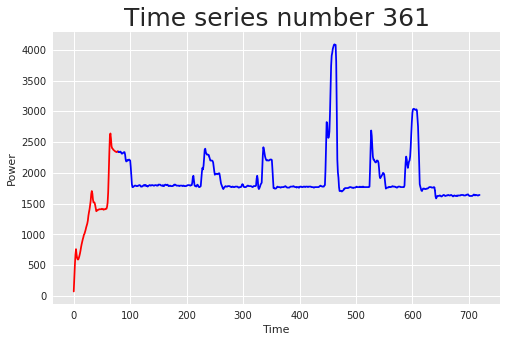

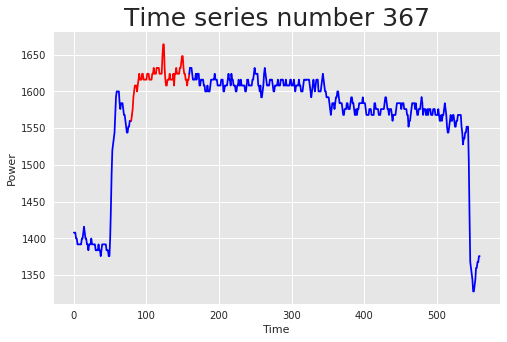

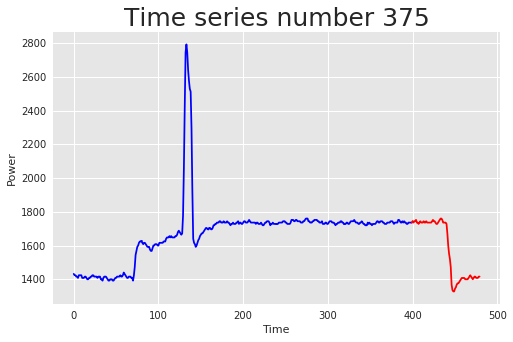

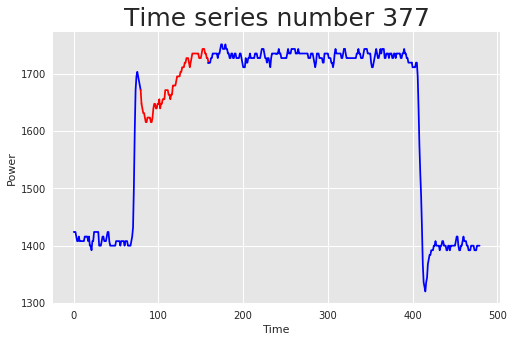

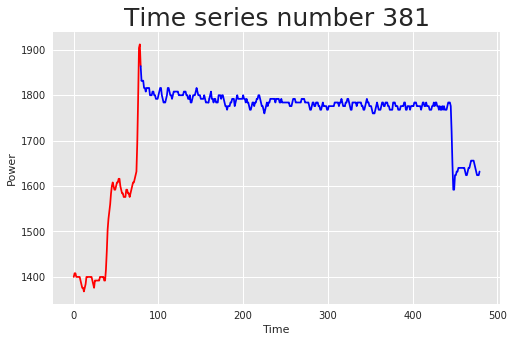

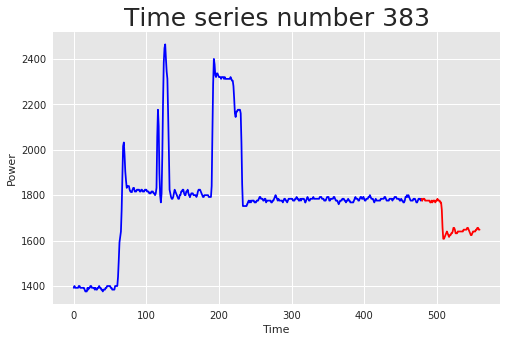

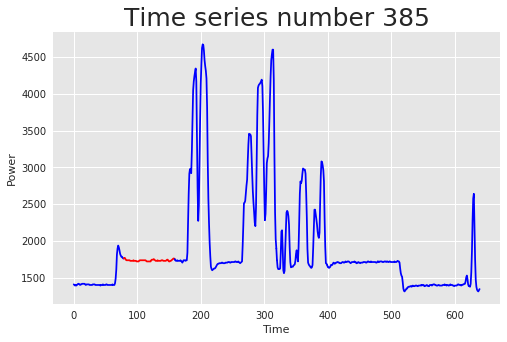

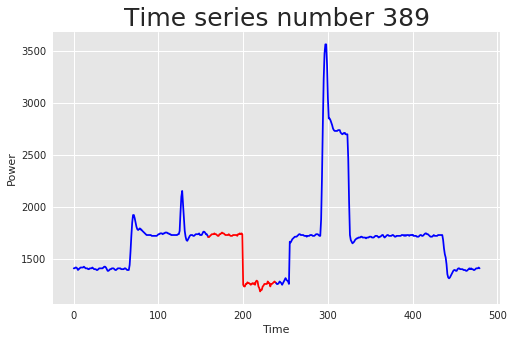

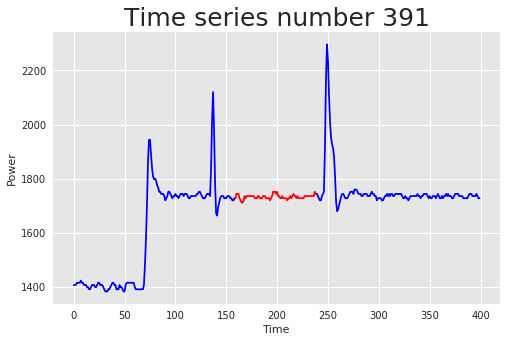

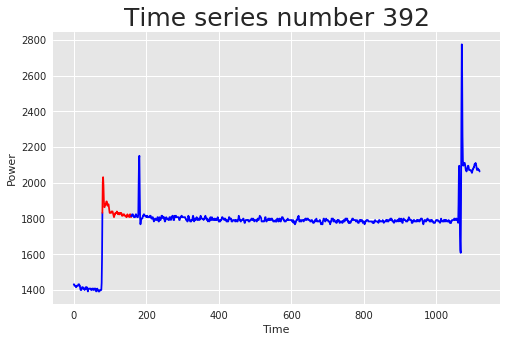

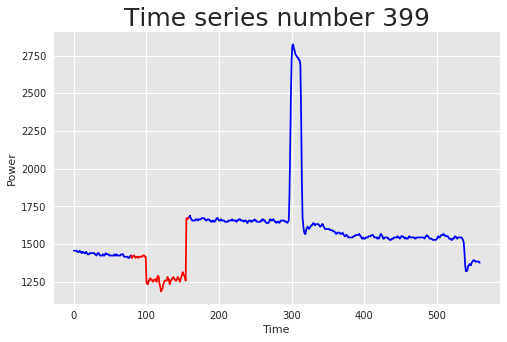

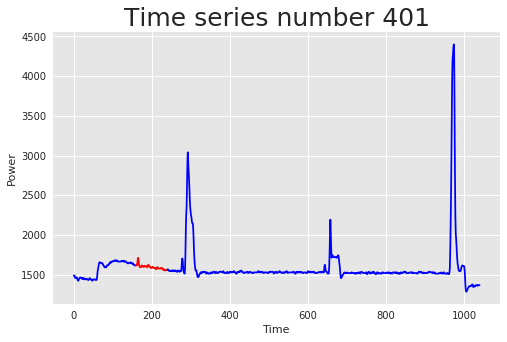

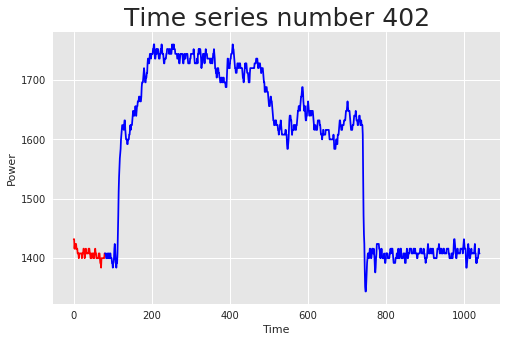

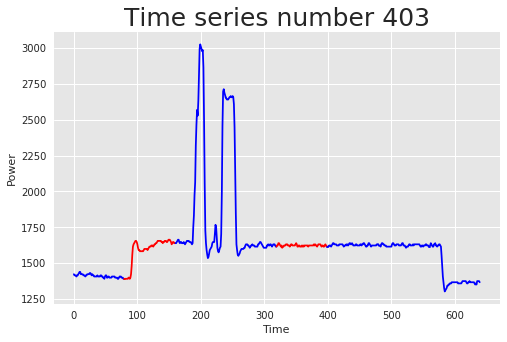

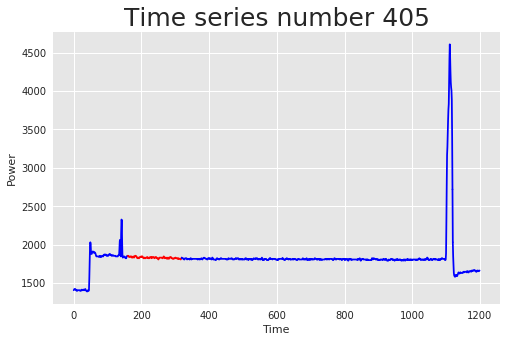

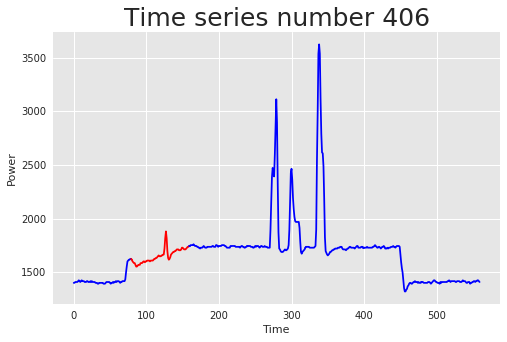

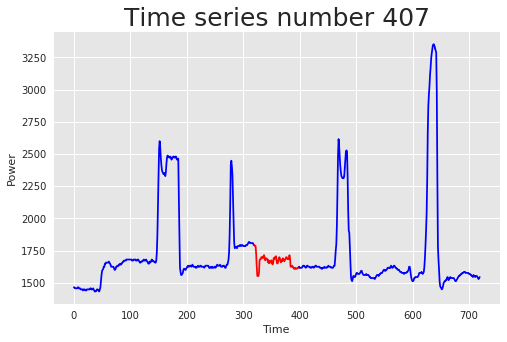

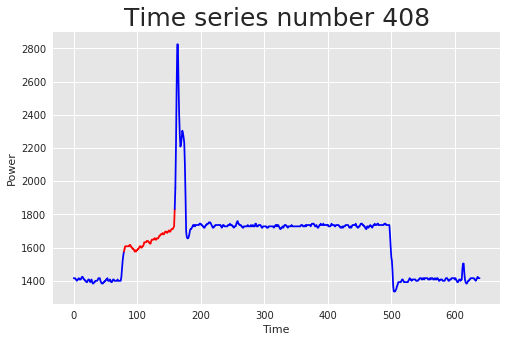

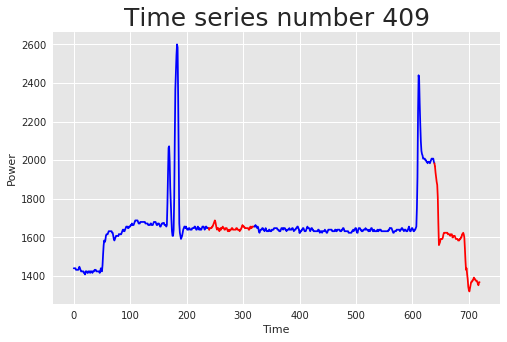

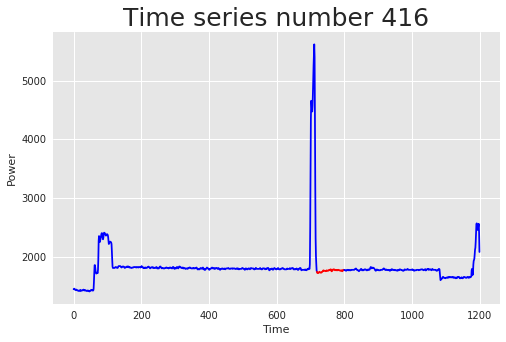

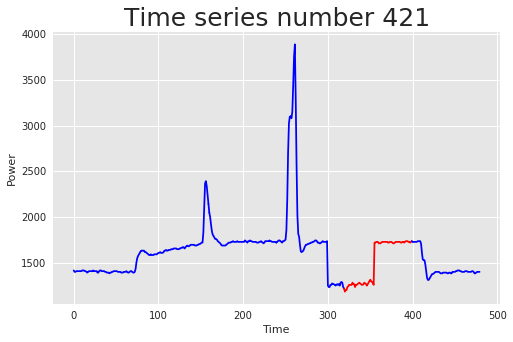

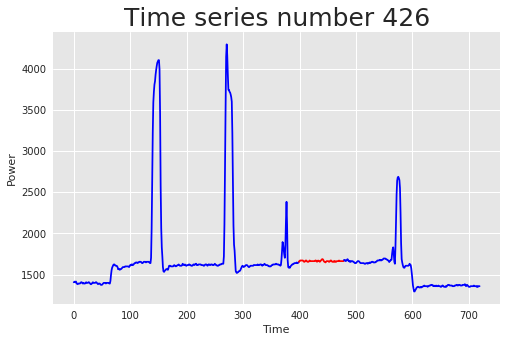

In [50]:
for num in ind_series_anom:
    fig, ax = plt.subplots(figsize=(8, 5))
    TS = data_fen_test[data_fen_test["serie"] == num]["valeurs"].values
    anoms = data_fen_test[data_fen_test["serie"] == num]["anomalie"].values
    title_obj = plt.title("Time series number " + str(num), size=25)
    for (i, x), anom in zip(enumerate(TS), anoms):
        
        if i > 0:  # Raccordement
            ax.plot([N * i - 1, N * i], [last, x[0]], "br"[anom])

        ax.plot(range(N * i, N * (i + 1)),  x, "br"[anom])
        ax.set_xlabel("Time")
        ax.set_ylabel("Power")
        last = x[-1]
    
    plt.show()

In [51]:
print("Séries anormales détectées : ", list(ind_series_anom))

Séries anormales détectées :  [300, 305, 308, 310, 316, 321, 322, 327, 331, 332, 335, 336, 346, 348, 349, 353, 356, 361, 367, 375, 377, 381, 383, 385, 389, 391, 392, 399, 401, 402, 403, 405, 406, 407, 408, 409, 416, 421, 426]


**Bilan : On arrive à détecter quelques anomalies, surtout celles de type IV.**